In [5]:
%matplotlib inline
import numpy as np
import argparse
import os
import tensorflow as tf
from PIL import Image
from io import BytesIO
import glob
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import datetime
import csv

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [7]:
def load_model(model_path):
    model = tf.saved_model.load(model_path)
    return model

In [8]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: a file path (this can be local or on colossus)

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [9]:
def run_inference_for_single_image(model, image):
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # Run inference
    output_dict = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key: value[0, :num_detections].numpy()
                   for key, value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict['detection_masks'], output_dict['detection_boxes'],
            image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

In [43]:
def run_inference(model, category_index, image_path, IMAGE_SIZE):
    if os.path.isdir(image_path):
        "Multiple image inference"
        image_paths = []
        for file_extension in ('*.png', '*jpg'):
            image_paths.extend(glob.glob(os.path.join(image_path, file_extension)))
        """add iterator here"""
        print(image_paths)
        i = 0
        for i_path in image_paths:
            gambar = Image.open(i_path)
            # Get the width and height of the image
            image_width, image_height = gambar.size
            image_np = load_image_into_numpy_array(i_path)

            # Actual detection.
            output_dict = run_inference_for_single_image(model, image_np)
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                output_dict['detection_boxes'],
                output_dict['detection_classes'],
                output_dict['detection_scores'],
                category_index,
                instance_masks=output_dict.get('detection_masks_reframed', None),
                use_normalized_coordinates=True,
                line_thickness=8)
            """The existing plt lines do not work on local pc as they are not setup for GUI
                Use plt.savefig() to save the results instead and view them in a folder"""

            plt.imshow(image_np)
            plt.show()
            i = i + 1
    else:
        "Single image inference"
        gambar = Image.open(image_path)
        # Get the width and height of the image
        image_width, image_height = gambar.size
        image_np = load_image_into_numpy_array(image_path)

        # Actual detection.
        output_dict = run_inference_for_single_image(model, image_np)
        
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            instance_masks=output_dict.get('detection_masks_reframed', None),
            use_normalized_coordinates=True,
            line_thickness=8)

        # Display the image with detection results
        plt.imshow(image_np)
        plt.show()


In [58]:
model_path = "inference_graph_resnet50_adam\saved_model"
labelmap_path = "labelmap.pbtxt"
image_path = r"test_images\karies\test10.jpg"
IMAGE_SIZE = (12, 8)

In [18]:
model = load_model(model_path)
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)

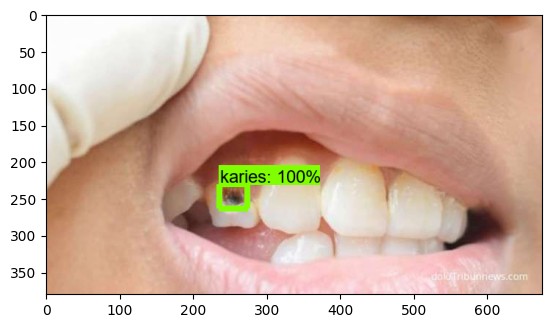

In [59]:
run_inference(model, category_index, image_path, IMAGE_SIZE)